In [1]:
import torch
import torchvision 
from torchvision import datasets, models, transforms

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA IS UNAVAILABLE IN THIS INSTANCE. TRAINING WILL RUN ON CPU')
else:
    print('CUDA IS AVAILABLE. TRAINING WILL RUN ON DISCRETE GPU')


CUDA IS AVAILABLE. TRAINING WILL RUN ON DISCRETE GPU


In [3]:
vgg19 = models.vgg19_bn(pretrained=True, progress=True)
print(vgg19)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [4]:
for param in vgg19.features.parameters():
    param.requires_grad=False

In [5]:
# import torch.nn as nn
# classes = ['bacterial', 'normal', 'virus']
# in_f = vgg19.classifier[6].in_features
# vgg19.classifier[6] = nn.Linear(in_features=in_f, out_features=len(classes), bias=True)
# print(vgg19.classifier[6])

# if train_on_gpu:
#     vgg19.cuda()

In [6]:
import torch.nn as nn
classes = ['bacterial', 'normal', 'virus']
in_f = vgg19.classifier[6].out_features
vgg19.classifier.add_module(module = nn.ReLU(inplace=True), name = '7')
vgg19.classifier.add_module(module = nn.Dropout(p=0.5, inplace=False), name='8')
vgg19.classifier.add_module(module= nn.Linear(in_features = in_f, out_features = len(classes), bias=True), name='9')
print(vgg19.classifier)

if train_on_gpu:
    vgg19.cuda()

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (7): ReLU(inplace=True)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=1000, out_features=3, bias=True)
)


In [7]:
import torch.optim as optim 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19.classifier.parameters(), lr=0.001)

In [8]:
train_dir = 'data/workdir'
test_dir = 'data/testdir'
image_transformer = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=image_transformer)
test_data = datasets.ImageFolder(test_dir, transform=image_transformer)
print("Length of the Training Data in Total: ")
print(len(train_data))
print("Length of the Test Data in Total: ")
print(len(test_data))
print("Details about the Training Data: ")
print(train_data)
print("Details about the Test Data: ")
print(test_data)

batch_size = 20
num_workers=0

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=num_workers, 
                                          shuffle=True)

Length of the Training Data in Total: 
5233
Length of the Test Data in Total: 
624
Details about the Training Data: 
Dataset ImageFolder
    Number of datapoints: 5233
    Root location: data/workdir
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Details about the Test Data: 
Dataset ImageFolder
    Number of datapoints: 624
    Root location: data/testdir
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [10]:
import sys
epochs = 10
if train_on_gpu:
    sys.stderr.write("Training Started on CUDA...")
else:
    sys.stderr.write(" GPU is not Found. Training Started on CPU...")
    
for epoch in range(1, epochs+1):
    train_loss = 0.0
    for batch, (data, label) in enumerate(train_loader):
        if train_on_gpu:
            data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output=vgg19(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if batch % 20 == 19:
            print("Epoch {} : Batch {} : Train Batch Loss: {}".format(epoch,batch+1, train_loss/20))
            train_loss = 0.0

Training Started on CUDA...

Epoch 1 : Batch 20 : Train Batch Loss: 1.0811160027980804
Epoch 1 : Batch 40 : Train Batch Loss: 0.9925779491662979
Epoch 1 : Batch 60 : Train Batch Loss: 0.8734047204256058
Epoch 1 : Batch 80 : Train Batch Loss: 0.902237743139267
Epoch 1 : Batch 100 : Train Batch Loss: 0.8362188398838043
Epoch 1 : Batch 120 : Train Batch Loss: 0.7934643059968949
Epoch 1 : Batch 140 : Train Batch Loss: 0.7857387334108352
Epoch 1 : Batch 160 : Train Batch Loss: 0.7879127115011215
Epoch 1 : Batch 180 : Train Batch Loss: 0.6978478893637657
Epoch 1 : Batch 200 : Train Batch Loss: 0.7423443213105202
Epoch 1 : Batch 220 : Train Batch Loss: 0.7132780596613884
Epoch 1 : Batch 240 : Train Batch Loss: 0.6849396839737892
Epoch 1 : Batch 260 : Train Batch Loss: 0.6805899575352669
Epoch 2 : Batch 20 : Train Batch Loss: 0.7155100613832474
Epoch 2 : Batch 40 : Train Batch Loss: 0.635879622399807
Epoch 2 : Batch 60 : Train Batch Loss: 0.6839319258928299
Epoch 2 : Batch 80 : Train Batch Loss: 0.6699374884366989
Epoch 2

In [2]:
import os
if not os.path.exists('model'):
    os.makedirs('model')

In [12]:
model_path = os.path.join('model', 'md')
torch.save(vgg19.state_dict(), model_path)

In [10]:
import os
model_path = os.path.join('model', 'md')
vgg19.load_state_dict(torch.load(model_path))
vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

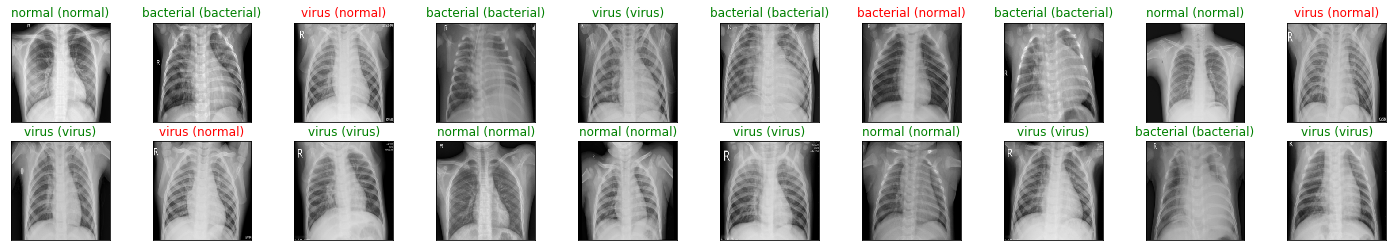

In [12]:
import numpy as np
import matplotlib.pyplot as plt
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg19(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [29]:
train_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg19.eval() # eval mode

# iterate over test data
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg19(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    train_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i < len(target.data):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))
print('\nTrain Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Train Loss: 0.422173


Train Accuracy (Overall): 82% (4294/5233)


In [30]:
import sys
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg19.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg19(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i < len(target.data):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
sys.stderr.write('Test Loss: {:.6f}\n'.format(test_loss))
sys.stderr.write('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.714370

Test Accuracy (Overall): 78% (490/624)